# Analyzing Reddit's Sentimental Shifts during COVID-19

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Distilbert for sentiment analysis
# https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion?text=I+feel+a+bit+let+down
from transformers import pipeline

from tqdm import tqdm # for prgress bar

2023-11-23 20:25:33.305373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 20:25:34.103288: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 20:25:35.404541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-23 20:25:35.404630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Loading Comments and Submissions Data
We saw that loading in the text comments dataset requires a lot of memory. To help manage memory usage
when dealing with large datasets like this we decided to chunk. 

In [2]:
text_submissions_df = pd.read_csv("text_submissions.csv")

# to help manage memory usage for this large dataset we decided to chunk 
text_comments_df = pd.read_csv("text_comments.csv", iterator=True, chunksize=1000000,lineterminator='\n')

/home/ava/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Cleaning and Preprocessing
Our data processing includes the following:
- Bot Detection: The updated dataframes do not contain author names, but we have removed rows with `bot` or `mod` in the author names
- Removed Comments: If a comment has body [deleted] or [removed] then, we remove those as well

We will split `text_comments` to two time-based dataframes: before and after Feb 1, 2020, which similar to the paper is the date 
chosen for the start of the pandemic. Each of the 2 dataframes will have columns id, linkid, body, and created_utc. 

We note that it is be easier to deal with 2 smaller datasets but if necessary, we can concatenate the two daasets (pre-covid and during covid) later on.

In [7]:
lst = [] # will store dataframes after they have been pruned
count = 0
for chunk in text_comments_df: 
    count += 1
    # add each chunk of txt_comments to a df and append it to a list
    temp = chunk[["id", "link_id", "author", "body", "created_utc"]]
    lst.append(temp)
    print(count, end=' ')
    
# time to run: 5 mins

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [ ]:
temp = pd.DataFrame() # temporary stores dataframes for each chunk (not changing the data) 
lst = [] # stores dataframes after they have been pruned
count = 0
for chunk in text_comments_df: 
    print(count)
    # Add each chunk of txt_comments to a df and append it to a list
    temp = pd.DataFrame()
    temp = chunk[["id", "link_id", "author", "body", "created_utc"]]
    lst.append(temp)
    count+=1

# time to run: 5 mins

### Bot Detection and Removed Comments

In [3]:
# TODO (Q): Bot Detection not necessary for Posts? just for text_comments?

In [ ]:
lst_shape = [] # stores how many rows are in each small dataframe - so that we can keep track that we're not missing rows by the end

# Modify each dataframe in lst by removing deleted comments, removing comments from bots, dropping the author column, and changing created_utc into int type
for i in range(len(lst)):
    print(i, end=' ')

    # remove usernames that indicate it's a bot and comments that are [removed] and [deleted]
    lst[i] = lst[i][~((lst[i]["body"] == "[removed]") | (lst[i]["body"] == "[deleted]") | lst[i]["author"].str.lower().str.contains("bot|mod"))]
    # we're not keeping author column
    lst[i] = lst[i].drop(columns=['author'])
    # transform date into int
    lst[i]['created_utc'] = lst[i]['created_utc'].astype(int)
    lst_shape.append(lst[i].shape[0])
    # time: 10m
    

In [ ]:
sum(lst_shape) # the total number of comments after pruning: 36449566

### Splitting comments to pre-pandemic and pandemic times

In [ ]:
# dataframes that will only have comments split based on Feb 01, 2022 UTC
# start of the pandemic: February 1, 2020  

lst_precovid, lst_postcovid = [], []
start_of_covid = 1580515200 # created_at is a UNIX timestamp. Feb 1, 2020 00:00:00 UTC = 1580515200

# for each dataframe in lst, create two dataframes that has comments based on dates and append it to the correct list
for i in range(len(lst)): 
    print(i, end=' ')
    # Pre-covid 
    lst_precovid.append(lst[i][lst[i]["created_utc"] < start_of_covid])
    # Post-covid 
    lst_postcovid.append(lst[i][lst[i]["created_utc"] >= start_of_covid])

# time to run: 7-10m

In [ ]:
# concatenate all dataframes that have comments before Feb 1, 2020 UTC into 1 dataframe
df_comments_precovid = pd.concat(lst_precovid) # time to run: 2-3m

# Concatenate all dataframes that have comments on or after Feb 1, 2020 UTC into 1 dataframe
df_comments_postcovid = pd.concat(lst_postcovid) # time to run: 3min

In [ ]:
# TODO remove?
# print(df_comments_precovid.head(1))
# print(df_comments_postcovid.shape) # (22814508, 4)
# check the sizes are the same: 40721549 index. 40721550 rows total
# 22814508+13635058 = sum(lst_shape) = 36449566
# df_comments_pre.to_csv('df_comments_pre.csv') # time: 
# df_comments_postcovid.to_csv('data/df_comments_post.csv') # time: 

### Other pre-processing for submissions

In [4]:
# Dropping columns that aren't useful for us in order to make the dataframes smaller
text_submissions_df=text_submissions_df.drop(columns=['score'])

# Drop submissions with title or text that is empty or na
text_submissions_df.drop(text_submissions_df[text_submissions_df['title'].isna() | (text_submissions_df['title'] == '')].index, inplace=True)
text_submissions_df.drop(text_submissions_df[text_submissions_df['selftext'].isna() | (text_submissions_df['selftext'] == '')].index, inplace=True)
# text_submissions_df.dropna(subset=['title'], inplace=True) # Drop na or empty titles

# Drop this row because it has an invalid date and other columns are nan
text_submissions_df=text_submissions_df[~(text_submissions_df['created_utc'] == "CPTSD")]

text_submissions_df['created_utc'] = text_submissions_df['created_utc'].astype(int)

### Splitting submissions pre-pandemic and pandemic times

In [5]:
# start of the pandemic as of February 1, 2020
# created_at is a UNIX timestamp. Feb 1, 2020 00:00:00 UTC = 1580515200
start_of_pandemic = 1580515200
text_submissions_df_pre = text_submissions_df[text_submissions_df["created_utc"] < start_of_pandemic]
text_submissions_df_post = text_submissions_df[text_submissions_df["created_utc"] >= start_of_pandemic]

In [2]:
# Downloading the 4 updated cvs which have cleaned up the data and split the comments and submissions csv files into 2 
# because they are smaller files, thus easier to load up and deal with
# text_submissions_df_pre.to_csv('data/text_submissions_pre.csv')
# text_submissions_df_post.to_csv("data/text_submissions_post.csv")

### Detecting COVID related posts
We detect submissions related to covid by searching in the their title for covid related words (with no case sensitivity).

In [24]:
covid_related_words = ['pandemic', 'covid']
search_pattern = '|'.join(covid_related_words)
covid_submissions = text_submissions_df[text_submissions_df['title'].str.contains(search_pattern, case=False)]

# printing the title of covid related posts
covid_submissions.head(5)

,id,author,created_utc,domain,is_self,selftext,title,subreddit
21,t3_krer7q,[deleted],1609902052,reddit.com,False,[deleted],James Charles calls out youtuber JennxPenn for...,BeautyGuruChatter
44,t3_fjm72g,ButterscotchFog,1584370462,i.redd.it,False,NaN,Shout out to creators whose content continues ...,BeautyGuruChatter
45,t3_fko0g4,[deleted],1584530758,i.redd.it,False,[deleted],(UPDATE) Mykie/GlamandGore addressing her firs...,BeautyGuruChatter
103,t3_jzy1ls,[deleted],1606191804,self.BeautyGuruChatter,True,[removed],"I’m just Curious as to why BGs, celebs, models...",BeautyGuruChatter
126,t3_j1dj17,[deleted],1601305059,jezebel.com,False,[deleted],"Jeffree Star Took Covid-19 Loans, Months After...",BeautyGuruChatter


## Exploratory Analysis

The pipeline is there.. no need to change it a lot

Explain how this is good

### Example of using distilbert
explain a bit

In [6]:
# sample - delete later
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier(["I love using transformers.", "I hate you so much"],)
prediction = classifier("I love using transformers.",)
prediction

/home/ava/.local/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'sadness', 'score': 0.007511448580771685},
  {'label': 'joy', 'score': 0.8325576186180115},
  {'label': 'love', 'score': 0.014407153241336346},
  {'label': 'anger', 'score': 0.13556727766990662},
  {'label': 'fear', 'score': 0.008320360444486141},
  {'label': 'surprise', 'score': 0.0016362066380679607}]]

### Average submission sentiment score pre-pandemic
We want to find the average score (0-1) for each sentiment (sadness, joy, love, anger, fear, surprise) for submissions and comments for posts pre-pandemic. 

In [7]:
# TODO for now we do it for submissions - figure it out for comments as well? - takes multiple hours
# TODO even for submissions selftext it's taken 10-11 hours.. so just doing it with title right now
# TODO also there's a limit to the characters for this classifier

# TODO write about selftext is too long for classifier and we want split it and maybe take an avg of the scores for each
# TODO split? and also do this for comments for each submissions along with submission selftext

# for now take 5% of text_submissions_df_pre (100% of the data takes >10 hours)
ten_percent = int(len(text_submissions_df_pre) * 0.05)
text_submissions_df_pre_subset = text_submissions_df_pre.head(ten_percent)

# add new columns in submissions dataframe for each emotion and set all to NaN
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for emotion in emotions:
    text_submissions_df_pre_subset[emotion] = float('NaN')

def get_scores_and_update(row):
    scores = classifier(row['title'])[0] # selftext
    for score in scores:
        emotion = score['label']
        row[emotion] = score['score']
    return row
  
# extract score for each emotion and set the score to the particular column
total_rows = len(text_submissions_df_pre_subset)
with tqdm(total=total_rows) as pbar:
  for index, row in text_submissions_df_pre_subset.iterrows():
      scores = classifier(row['title'])[0]
      for score in scores:
          emotion = score['label']
          text_submissions_df_pre_subset.at[index, emotion] = score['score']
      
      pbar.update(1)
      pbar.set_description(f'Processing: {((index + 1) / total_rows) * 100:.2f}%')  # Display progress percentage

/tmp/ipykernel_5241/2614509663.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_submissions_df_pre_subset[emotion] = float('NaN')
Processing: 4252.75%: 100%|██████████| 33518/33518 [15:05<00:00, 37.00it/s]


In [8]:
# average of the 5% of the titles of all posts pre-pandemic
emotion_to_avg_score = {}
for e in emotions:
  emotion_to_avg_score[e] = text_submissions_df_pre_subset[e].mean()
  print(f"average {e} score: {emotion_to_avg_score[e]}")

average sadness score: 0.08333218761260267
average joy score: 0.39390795732316913
average love score: 0.014010731028408201
average anger score: 0.35626362880260765
average fear score: 0.14184019473937085
average surprise score: 0.0106453003270222


### Frequency distribution
Now that we've calculated the average sentiment score for a pre-pandemic post for every sentiment, 
we want to visualize how many submissions and comments have sentiment score above and below the average
sentiment scores.

NOTE: For now we'll look at submissions only because we have yet to find an efficient way to process the full
text datasets. The pipeline won't need much changing then.

In [9]:
# store counts of submissions that have below and above the average sentiment scores
above_avg, below_avg = {}, {}
submissions_subset = text_submissions_df_pre_subset

for e in emotions:
    avg_emotion_score = emotion_to_avg_score[e]
    
    above_count = submissions_subset[e][submissions_subset[e] > avg_emotion_score].count()
    below_count = submissions_subset[e][submissions_subset[e] < avg_emotion_score].count()
    
    above_avg[e] = above_count
    below_avg[e] = below_count

print('above average counts:', above_avg)
print('below average counts:', below_avg)

above average counts: {'sadness': 4677, 'joy': 14169, 'love': 2295, 'anger': 14090, 'fear': 9499, 'surprise': 2944}
below average counts: {'sadness': 28841, 'joy': 19349, 'love': 31223, 'anger': 19428, 'fear': 24019, 'surprise': 30574}


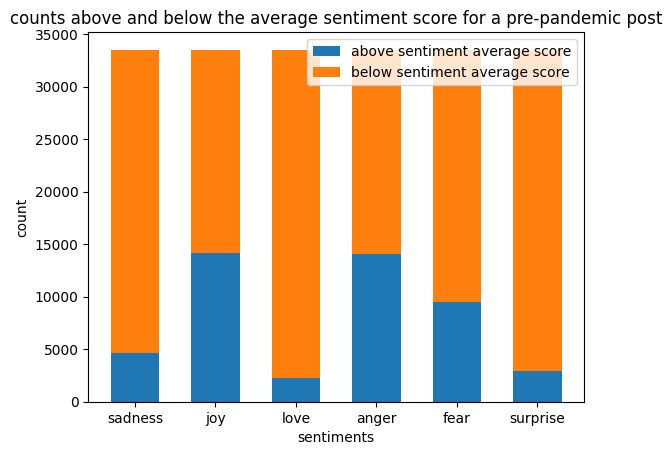

In [21]:
plt.bar(above_avg.keys(), above_avg.values(), label='above sentiment average score', width=.6)
plt.bar(below_avg.keys(), below_avg.values(), bottom=list(above_avg.values()), label='below sentiment average score', width=.6)

plt.xlabel('sentiments')
plt.ylabel('count')
plt.title('counts above and below the average sentiment score for a pre-pandemic post')
plt.legend()
plt.show()

We can also make a scatter plot of the sentiment scores to see the correlations between sentiments.